## Week 6 Video Notebook: Decision Trees

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing

from tqdm import tqdm

# globals

random_state = 42

# utility code

def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

# To avoid constant warnings about jobs: 
#        UserWarning: A worker stopped while some jobs were given to the executor. 
#        This can be caused by a too short worker timeout or by a memory leak.

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


### Load and Prepare the Boston Housing Dataset


In [2]:
# Load the dataset
import kagglehub

# Download latest version

path = kagglehub.dataset_download("vikrishnan/boston-house-prices")

# print("Path to dataset files:", path)

feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df_raw = pd.read_csv(path+'/housing.csv', header=None, delimiter=r"\s+", names=feature_names)
df_raw.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


There has been an ethical controversy about column B which you can read about online; for our purposes, I will simply delete the offending feature **B**. 

In [4]:
df = df_raw.drop(columns="B")

# Remove 'B' and 'MEDV' from feature names
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']


In [5]:
# Split dataset 

X = df.drop(columns="MEDV")  # All columns except MEDV
y = df["MEDV"]               # Only the MEDV column

test_size = 0.1      # with very small datasets, this works better. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=random_state)

len(X_train), len(X_test)

(455, 51)

## Part One: Building and Tuning Decision Trees

### Basic Decision Tree Regressor

We will start by writing a wrapper around `DecisionTreeRegressor` to facilitate our investigations. 

In [6]:
# Wrapper around DecisionTreeRegressor with cross-validation
def run_decision_tree_regressor(X_train,
                                y_train,
                                max_depth=None,          # Default parameters for DecisionTreeRegressor
                                max_features=None,       
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_leaf_nodes=None,
                                criterion='squared_error',
                                ccp_alpha=0.0,
                                cv=5,
                                random_state=random_state,                          
                                n_jobs=-1,              
                                visualize=True
                               ):                
    # Initialize the DecisionTreeRegressor
    decision_tree_model = DecisionTreeRegressor(
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        criterion=criterion,
        ccp_alpha=ccp_alpha,
        random_state=random_state
    )

    # Perform cross-validation and return mean CV MSE
    neg_mse_scores = cross_val_score(decision_tree_model, X_train, y_train,
                                     scoring='neg_mean_squared_error',
                                     cv=cv,
                                     n_jobs=n_jobs)
    mean_cv_mse = -np.mean(neg_mse_scores)  # Convert negative MSE back to positive

    # Train the model on the full training set for visualization purposes
    if visualize:
        decision_tree_model.fit(X_train, y_train)  # Train on full training data for visualization
        plt.figure(figsize=(12, 6))
        plot_tree(decision_tree_model, feature_names=feature_names, filled=True, rounded=True, precision=4)
        plt.title(f"Decision Tree Structure (max_depth={max_depth})")
        plt.show()

    return mean_cv_mse

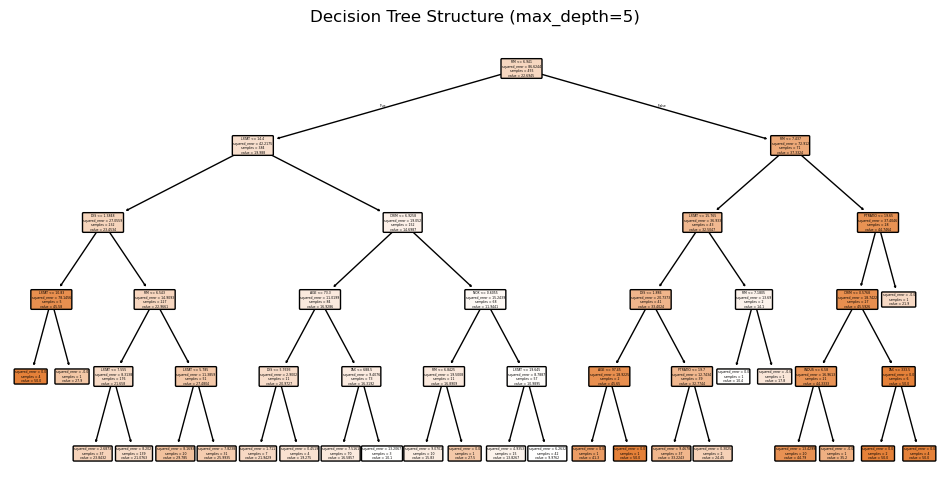

21.61029806493537

In [23]:
run_decision_tree_regressor(X_train,y_train,max_depth=5)

### Your Turn!

Play around with different depths and examine the tree carefully in each case and observe the resulting MSE. What happens when you set `max_depth` equal to `None`?


### Round One....

100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.10it/s]


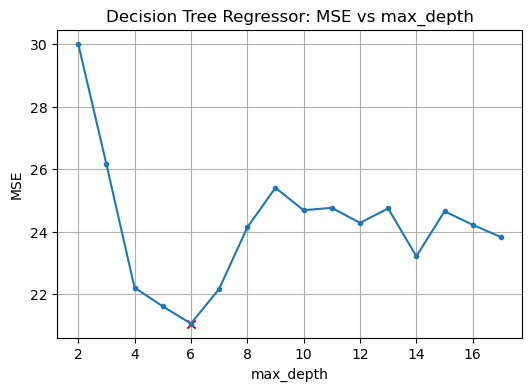

Minimum MSE 21.0584 found at x = 6
Execution Time: 2.67s


In [8]:
# Plot a max_depth vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'max_depth'  

parameter_list = range(2,18)      

MSEs = []

for d in tqdm(parameter_list):

    MSEs.append( run_decision_tree_regressor(X_train,y_train,
                                             max_depth = d,                      
                                             max_features=None,
                                             min_samples_split=2,
                                             min_samples_leaf=1,
                                             max_leaf_nodes=None,    
                                             criterion='squared_error',
                                             ccp_alpha=0.0,
                                             random_state=random_state,
                                             cv=5,
                                             n_jobs= -1,
                                             visualize=False
                                            ) ) 
     

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 76.18it/s]


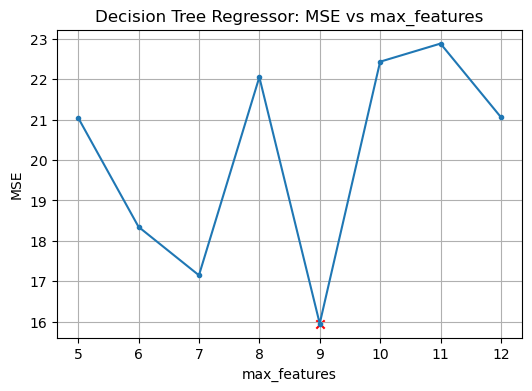

Minimum MSE 15.9501 found at x = 9
Execution Time: 0.18s


In [9]:
# Plot a max_features vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'max_features'  

parameter_list = range(5,13)      

MSEs = []

for mf in tqdm(parameter_list):

    MSEs.append( run_decision_tree_regressor(X_train,y_train,
                                             max_depth = 6,                      
                                             max_features=mf,
                                             min_samples_split=2,
                                             min_samples_leaf=1,
                                             max_leaf_nodes=None,    
                                             criterion='squared_error',
                                             ccp_alpha=0.0,
                                             random_state=random_state,
                                             cv=5,
                                             n_jobs= -1,
                                             visualize=False
                                            ) ) 

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 12.33it/s]


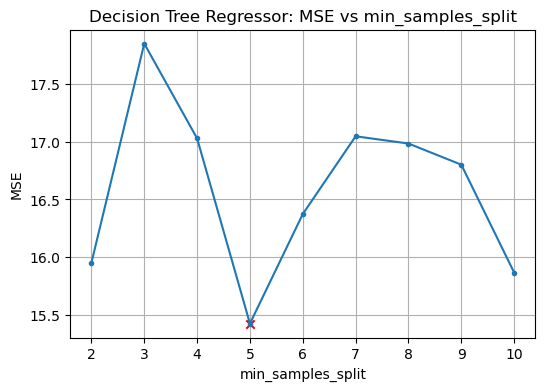

Minimum MSE 15.4234 found at x = 5
Execution Time: 0.77s


In [10]:
# Plot a min_samples_split vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'min_samples_split'  

parameter_list = range(2,11)      

MSEs = []

for mss in tqdm(parameter_list):

    MSEs.append( run_decision_tree_regressor(X_train,y_train,
                                             max_depth = 6,                      
                                             max_features=9,
                                             min_samples_split=mss,
                                             min_samples_leaf=1,
                                             max_leaf_nodes=None,    
                                             criterion='squared_error',
                                             ccp_alpha=0.0,
                                             random_state=random_state,
                                             cv=5,
                                             n_jobs= -1,
                                             visualize=False
                                            ) ) 

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.47it/s]


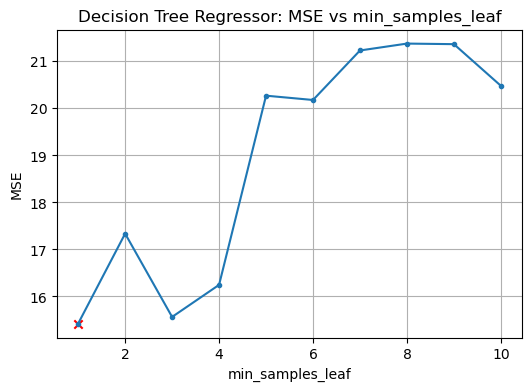

Minimum MSE 15.4234 found at x = 1
Execution Time: 0.17s


In [11]:
# Plot a min_samples_leaf vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'min_samples_leaf'  

parameter_list = range(1,11)      

MSEs = []

for msl in tqdm(parameter_list):

    MSEs.append( run_decision_tree_regressor(X_train,y_train,
                                             max_depth = 6,                      
                                             max_features=9,
                                             min_samples_split=5,
                                             min_samples_leaf=msl,
                                             max_leaf_nodes=None,    
                                             criterion='squared_error',
                                             ccp_alpha=0.0,
                                             random_state=random_state,
                                             cv=5,
                                             n_jobs= -1,
                                             visualize=False
                                            ) ) 

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|███████████████████████████████████████████| 45/45 [00:00<00:00, 75.36it/s]


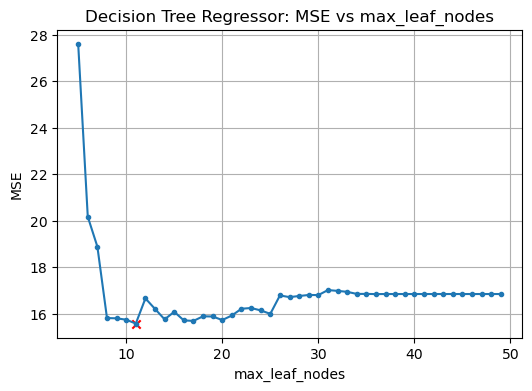

Minimum MSE 15.5748 found at x = 11
Execution Time: 0.64s


In [12]:
# Plot a max_leaf_nodes vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'max_leaf_nodes'  

parameter_list = range(5,50)      

MSEs = []

for mln in tqdm(parameter_list):

    MSEs.append( run_decision_tree_regressor(X_train,y_train,
                                             max_depth = 6,                      
                                             max_features=9,
                                             min_samples_split=5,
                                             min_samples_leaf=1,
                                             max_leaf_nodes=mln,    
                                             criterion='squared_error',
                                             ccp_alpha=0.0,
                                             random_state=random_state,
                                             cv=5,
                                             n_jobs= -1,
                                             visualize=False
                                            ) ) 

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))  



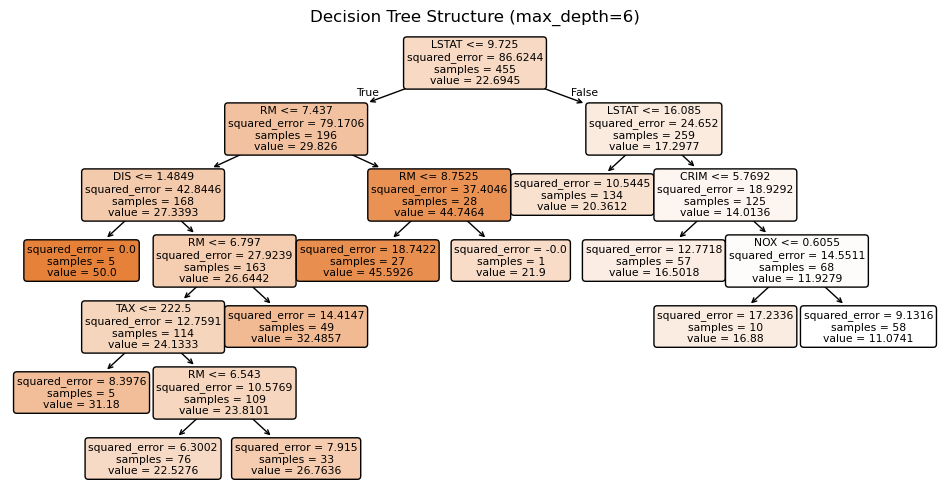

15.574844779587144

In [13]:
run_decision_tree_regressor(X_train,y_train,
                             max_depth = 6,                      
                             max_features=9,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             max_leaf_nodes=11,    
                             criterion='squared_error',
                             ccp_alpha=0.0,
                             random_state=random_state,
                             cv=5,
                             n_jobs= -1,
                             visualize=True
                            )

## Final Exam Time!

Let's try our model on the testing set.

In [14]:
# run model through test set

decision_tree_model = DecisionTreeRegressor(
        max_depth=6,
        max_features=9,
        min_samples_split=5,
        min_samples_leaf=1,
        max_leaf_nodes=11
    )

decision_tree_model.fit(X_train,y_train)

y_test_pred = decision_tree_model.predict(X_test)

test_MSE = mean_squared_error(y_test_pred,y_test)

print(f"Test MSE: {test_MSE:.4f}")

Test MSE: 9.6726


## Your Turn!

Are our parameter choices optimal?  Go back to the cell where we explored the `max_depth` parameter, and
retrofit the values from the first round and see if you can get an improvement.  Note that you can't just
do a couple without any change and assume the rest are still optimal. Any time you change one parameter in
principle any other parameter might have to change as well. In other words, the parameters are **not** independent
and you have to deal with a tradeoff. 


### Optional

We did not experiment with the parameters `criterion` or `cv`. Complete your investigation by exploring whether these have an effect, either in precision or efficiency. Try LOOCV for `cv` as well. 


##  Part Two: Controlling Tree Complexity

In this section, we will consider how to use the complexity parameter `ccp_alpha` to build decision trees.
The interesting thing about this parameter is that it is kind of a "universal" parameter which can
replace all the other parameter choices.

We will use `GridSearchCV` to explore the search space of parameter values. We will extract the necessary information so as to plot `ccp_alpha` vs MSE. 

We can use this approach in two ways:

- Set all parameters to their defaults and let `ccp_alpha` specify how much to prune back the (large) tree that results.
- Set some not-very-restrictive values for the other parameters and again let `cpp_alpha` prune back this not-quite-as-large tree. 

But before we do that, please take the time to play around with this parameter and see how it changes the whole game!


## Your Turn First!

In order to get a feel for how the pruning works, run the following with various values of `ccp_value` holding
the other parameters at their defaults. Then try adding back the other parameters, including the "optimal" ones we found above. 

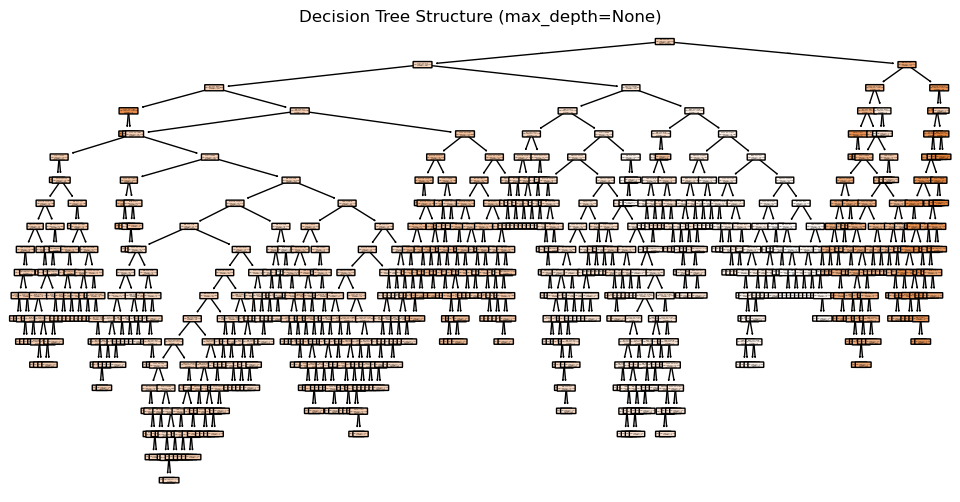

24.888813186813184

In [15]:
run_decision_tree_regressor(X_train,
                                y_train,
                                max_depth=None,          # Default parameters for DecisionTreeRegressor
                                max_features=None,       
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_leaf_nodes=None,
                                criterion='squared_error',
                                ccp_alpha=0.0,
                                cv=5,
                                random_state=random_state,                          
                                n_jobs=-1,              
                                visualize=True
                               )

### Ok, let's try it with grid search!

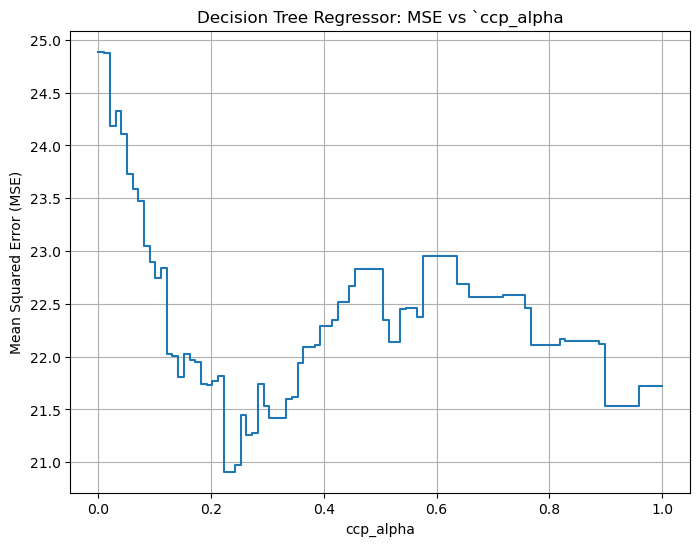

Minimum MSE 20.9099 found at ccp_alpha = 0.22222222222222224
Execution Time: 0.22s


In [16]:
# Grid search for best ccp_alpha, showing plot, only useful for starting with defaults


start_time = time.time()

# Define parameter grid for GridSearchCV
param_grid = {

    'ccp_alpha' : np.linspace(0.0,1,100),

}

# Initialize the DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Extract the results
results = grid_search.cv_results_
alphas = grid_search.param_grid['ccp_alpha']
mean_test_scores = -results['mean_test_score']  # Convert to positive MSE

# Find the best alpha and corresponding MSE
best_alpha = grid_search.best_params_['ccp_alpha']
best_mse = -grid_search.best_score_

# Plot the relationship between ccp_alpha and MSE
plt.figure(figsize=(8, 6))
plt.plot(alphas, mean_test_scores, drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Decision Tree Regressor: MSE vs `ccp_alpha")
plt.grid()
plt.show()

print(f"Minimum MSE {best_mse:.4f} found at ccp_alpha = {best_alpha}")
execution_time = time.time() - start_time
print(f"Execution Time: {execution_time:.2f}s")


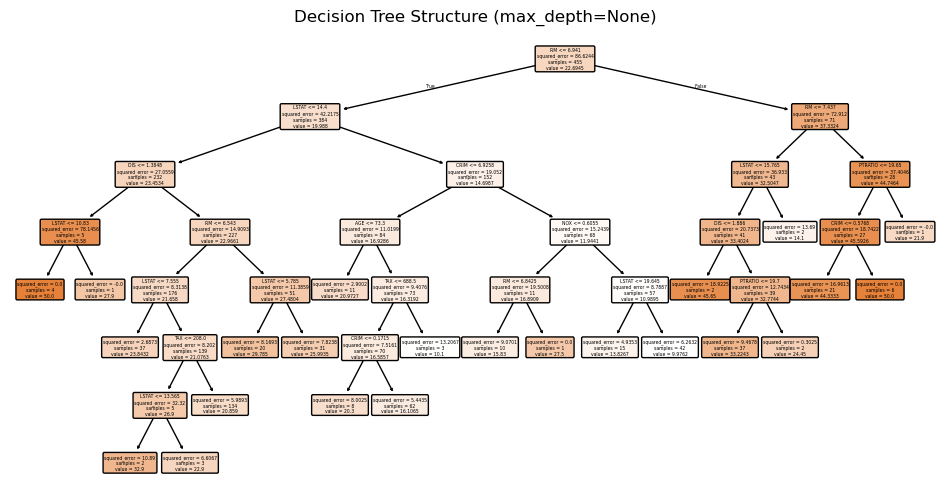

21.258843995865107

In [17]:
run_decision_tree_regressor(X_train,y_train,
                             ccp_alpha=0.26262626262626265,
                             visualize=True
                            )

In [18]:
# run model through test set

decision_tree_model = DecisionTreeRegressor(
        ccp_alpha = 0.26262626262626265
    )

decision_tree_model.fit(X_train,y_train)

y_test_pred = decision_tree_model.predict(X_test)

test_MSE = mean_squared_error(y_test_pred,y_test)

print(f"Test MSE: {test_MSE:.4f}")

Test MSE: 7.7039


In [19]:
# Grid search for best ccp_alpha in combination with other parameters

# Record start time
start = time.time()

# Define the model
tree_model = DecisionTreeRegressor(random_state=random_state)

# Define the parameter grid
param_dist = {
     'ccp_alpha' : np.linspace(0.0,1,10),
     'max_depth' : range(10,21),                      
     'max_features' : range(8,12),
    
}

# Use GridSearchCV to find the best parameters

search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=5,  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
    n_jobs=-1,  # Use all available cores
    return_train_score=True
)

# Or RandomizedSearchCV -- not as accurate but faster

# search = RandomizedSearchCV(
#     estimator=tree_model,
#     param_distributions=param_dist,
#     n_iter=20,  # Number of random combinations to test
#     scoring='neg_mean_squared_error',  # MSE but negated for maximization by RandomizedSearchCV
#     cv=5,  # Number of folds for cross-validation
#     n_jobs=-1,  # Use all available cores
#     random_state=random_state
# )

# Fit the GridSearchCV
search.fit(X_train, y_train)  

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Select relevant columns for readability
results = results[[
    'param_ccp_alpha',
    'param_max_depth',
    'param_max_features',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',  # Include training score
    'std_train_score',   # Include standard deviation of training score
    'rank_test_score'
]]

# Convert negative MSE to positive
results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

# Sort by rank (best scores first)
results = results.sort_values(by='rank_test_score')

# Rename columns for printing only
renamed_results = results.rename(
    columns={
        'param_param_ccp_alpha': 'ccp_alpha',
        'param_max_depth': 'max_depth',
        'param_max_features': 'max_features',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }
).drop(columns=['rank_test_score'])  # Drop the rank column for readability

# Print the results as a table
print("\nSearch Results (Top 10):\n")
print(renamed_results.head(10).to_string(index=False))  # Show the top 10 results with new headers

# Best parameters and test performance
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV MSE: {-search.best_score_:.4f}")

# Evaluate on the test set
y_pred_bagging = search.best_estimator_.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_bagging)

print(f"Test MSE:    {test_mse:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))


Search Results (Top 10):

 param_ccp_alpha  max_depth  max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
        0.222222         13             9      13.755861      2.005838          6.332874         0.608169
        0.333333         13             9      14.308464      1.512787          7.651934         0.378314
        0.555556         15             9      14.795579      2.768055          9.925450         0.114962
        0.666667         15             9      15.066303      2.976030         10.637691         0.538563
        0.444444         15             9      15.220503      2.725284          8.718974         0.595140
        0.777778         15             9      15.273234      2.906264         11.072019         0.754565
        0.222222         15             9      15.281888      4.279016          6.385231         0.503910
        0.333333         15             9      15.316301      3.532890          7.650418         0.380397
        0.111111   

In [20]:
# run model through test set

decision_tree_model = DecisionTreeRegressor(
                             max_depth = 15,                      
                             max_features=9,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_leaf_nodes=None,    
                             criterion='squared_error',
                             ccp_alpha=0.33333,
                             random_state=random_state,
    )

decision_tree_model.fit(X_train,y_train)

y_test_pred = decision_tree_model.predict(X_test)

test_MSE = mean_squared_error(y_test_pred,y_test)

print(f"Test MSE: {test_MSE:.4f}")

Test MSE: 11.3674


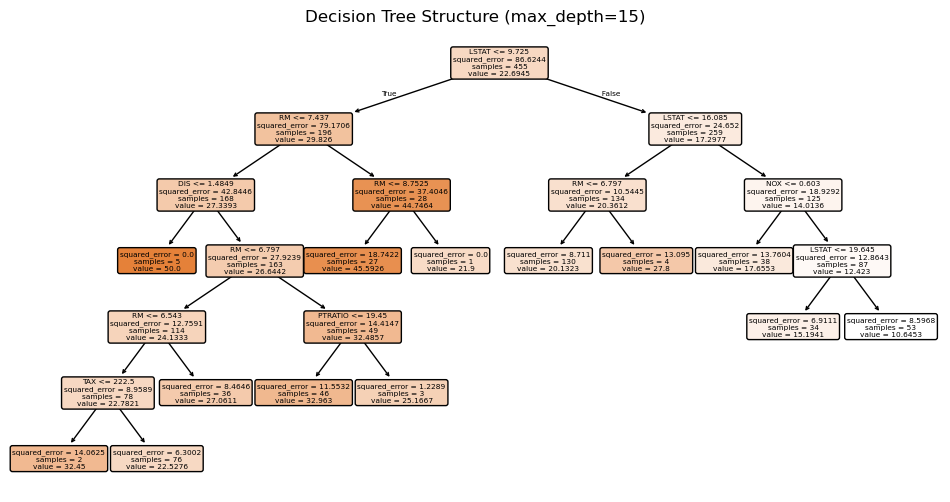

15.316301255946623

In [21]:
run_decision_tree_regressor(X_train,
                                y_train,
                                max_depth=15,          # Default parameters for DecisionTreeRegressor
                                max_features=9,       
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_leaf_nodes=None,
                                criterion='squared_error',
                                ccp_alpha=0.3333,
                                cv=5,
                                random_state=random_state,                          
                                n_jobs=-1,              
                                visualize=True
                               )

### Optional:

We did not try the other parameters (`min_samples_split`, etc.) with grid search. Add them to a grid search above with
appropriate ranges. Did they find an even better set of parameters?

## Appendix: Most Important Parameters and Best Practices


---

- **`criterion`:** Controls how the decision tree measures the quality of the splits during its construction.

    - 'squared_error': Minimizes the L2 loss using the mean of each terminal node.
    - 'friedman_mse': Refinement of squared error.
    - 'absolute_error': Minimizes the L1 loss using the median of each terminal node (inefficient!).  
    - **Best Practices:**
        - Use **'friedman_mse'** for most regression tasks as it might perform better, especially in the presence of noise.
        - Use **'absolute_error'** if outliers are a significant concern, but only when computational efficiency is not critical.

---

- **`max_depth`** {None, int}, default=None 
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain fewer than `min_samples_split` samples.  
  - **Best Practices:**
      - Set a reasonable value for `max_depth` (e.g., 10-20) to prevent overfitting, especially on small datasets.
      - Use **grid search** or **cross-validation** to identify the optimal depth for your dataset.
      - If you expect simple relationships in your data, consider a shallower tree for better generalization.

---

- **`min_samples_split`** {int, float}, default=2.  The minimum number of samples required to split an internal node.  
  - **Best Practices:**
      - Increase this value (e.g., 10) to prevent overfitting, especially when working with small datasets or noisy data.
      - For larger datasets, consider using a fraction (e.g., 0.05) to adapt to the dataset size.

---

- **`min_samples_leaf`** {int, float}, default=1.  The minimum number of samples required to be at a leaf node. A split at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches.   
  - **Best Practices:**
      - Increase this value (e.g., 5-10) to smooth predictions and prevent overfitting in regression tasks.
      - Use a fraction (e.g., 0.01) for larger datasets to ensure scalability and reduce overfitting.

---

- **`max_leaf_nodes`** (int), default=None.  Grow trees with `max_leaf_nodes` in best-first fashion. Best nodes are defined as relative reduction in impurity. If None, then the number of leaf nodes is unlimited.  
  - **Best Practices:**
      - Use this parameter to limit tree complexity and improve generalization.
      - Start with a value like 20-50 and tune via cross-validation.

---

- **`splitter`** {'best', 'random'}, default='best'.  The strategy used to choose the split at each node.  
  - **Best Practices:**
      - Use **'best'** for most cases, as it evaluates all features for the optimal split.
      - Use **'random'** for very large datasets or when training speed is more critical than accuracy.

---

- **`max_features`** {None, int, float, 'sqrt', 'log2'}, default=None.  The number of features to consider when looking for the best split:  
    - If 'sqrt', then `max_features = sqrt(n_features)`.
    - If 'log2', then `max_features = log2(n_features)`.
    - If None, then `max_features = n_features`.  
  - **Best Practices:**
      - Use **'sqrt'** or **'log2'** to reduce overfitting and improve training speed.
      - Use **grid search** to tune this parameter for datasets with many features.
      - For small datasets, `max_features=None` may be suitable.

---

- **`ccp_alpha`** {float}, default=0.0.  Complexity parameter used for Minimal Cost-Complexity Pruning. The larger the `ccp_alpha`, the more aggressive the pruning.

  - **Best Practices:**
      - Set all other parameters to their defaults initially and use `ccp_alpha` to control the pruning process.
      - Use **`GridSearchCV`** or **cross-validation** to find the optimal value of `ccp_alpha` for your dataset.
      - Start with small values (e.g., 0.001 or 0.01) and increase gradually to control tree complexity.
      - Use the **`cost_complexity_pruning_path`** method to visualize the relationship between `ccp_alpha` and tree performance.
      - Combine `ccp_alpha` with other parameters like `max_depth` or `min_samples_leaf` for additional control over complexity and overfitting.